# CSC413 Assignment 2: American Sign Language

**Deadline**: March 9, 2023 by 6pm

**Submission**: Compile and submit a PDF report containing your code, outputs,
and your written solutions. Do not use screenshots and images to present
textual code/output (other than legible, hand-written answer).
You may export the completed notebook on Google Colab, but if you do so
**it is your responsibly to make sure that your code and answers do not get cut off**.

**Late Submission**: Please see the syllabus for the late submission criteria.

**Working with a partner**: You may work with a partner for this assignment.
If you decide to work with a partner, please create your group on Markus by
the deadline, even if you intend to use grace tokens. Markus does not allow
you to create groups past the deadline, even if you have grace tokens remaining.

[American Sign Language (ASL)](https://en.wikipedia.org/wiki/American_Sign_Language)
is a complete, complex language that employs signs made by
moving the hands combined with facial expressions and postures of the body.
It is the primary language of many North Americans who are deaf and is one of several
communication options used by people who are deaf or hard-of-hearing.

The hand gestures representing English alphabets are shown below.

In this assignment, we will
classify a subset of these hand gesture images using convolutional neural networks.
Specifically, given an image of a hand showing one of the letters A-I, we want to detect
which letter is being represented.

We will explore several convolutional architectures.
While we will give you a tiny
big of starter code to help make data processing a bit easier,
you'll have a chance to build your neural network all by yourself!

You may modify the starter code as you see fit, including changing the signatures of
functions and adding/removing helper functions. However, please make sure that your
TA can understand what you are doing and why.

In [ ]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models, torchvision.datasets

import os

%matplotlib inline

## Question 1. Data

If you are using your own machine, download the data from the course website on Quercus.

If you are using Google Colab, download the data set to your Google Drive by going to
the link [https://drive.google.com/drive/folders/1aPL24P610NHLvt9exk6-B7SzGk3R8Q48?usp=sharing](https://drive.google.com/drive/folders/1aPL24P610NHLvt9exk6-B7SzGk3R8Q48?usp=sharing)
and selecting "Add to My Drive".
This is faster than downloading the data from the course website.

Then, mount Google Drive from your Google Colab notebook:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


The file structure we use is intentional,
so that we can use `torchvision.datasets.ImageFolder`
to help load our data and create labels.

In [ ]:
train_path = "/content/drive/MyDrive/Colab Notebooks/CSC413/A2/asl_data/train" # edit me
valid_path = "/content/drive/MyDrive/Colab Notebooks/CSC413/A2/asl_data/valid" # edit me
test_path = "/content/drive/MyDrive/Colab Notebooks/CSC413/A2/asl_data/test"   # edit me

train_data = torchvision.datasets.ImageFolder(train_path, transform=torchvision.transforms.ToTensor())
valid_data = torchvision.datasets.ImageFolder(valid_path, transform=torchvision.transforms.ToTensor())
test_data = torchvision.datasets.ImageFolder(test_path, transform=torchvision.transforms.ToTensor())

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if device.type == 'cuda':
    torch.cuda.set_device(device)

### Part (a) -- 2 pts

Read up on what `torchvision.datasets.ImageFolder` does for us here
[https://pytorch.org/vision/stable/datasets.html#torchvision.datasets.ImageFolder](https://pytorch.org/vision/stable/datasets.html#torchvision.datasets.ImageFolder)

We can iterate through the one training data point at a time like this:

In [ ]:
for x, y in train_data:
    print(x.shape)
    print(y)
    break # uncomment if you'd like

torch.Size([3, 224, 224])
0


What do the variables `x` and `y` contain? What is the shape of our images?
What are our labels? How did PyTorch generate these labels from the folder structure?

Before answering this question, you will need to look at the folder structure
and look at some images in the data set.

In [ ]:
# Your explanation goes here
# x: Represents each image in the form of tensor.
# y: Represents the category of the current image.

### Part (b) -- 2 pts

We saw in the earlier tutorials that PyTorch has a utility to help us
create minibatches with our data. We can use the same DataLoader helper
here:

In [ ]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=10, shuffle=True)

for x, y in train_loader:
    print(x.shape)
    print(y)
    break # uncomment if you'd like

torch.Size([10, 3, 224, 224])
tensor([1, 7, 0, 8, 2, 5, 0, 3, 0, 6])


What do the variables `x` and `y` contain? What are their shapes?
What data do they contain?

In [ ]:
# Your explanation goes here
# x: Represents a batch of input images
# y: Represents each image's corresponding category.

### Part (c) -- 1 pts

How many images are there in the training, validation, and test sets?

In [ ]:
# Your answer (and possibly code) goes here
print("Num of Img in Training Set:", len(train_data))
print("Num of Img in Valid Set:", len(valid_data))
print("Num of Img in Test Set:", len(test_data))

Num of Img in Training Set: 733
Num of Img in Valid Set: 207
Num of Img in Test Set: 223


### Part (d) -- 3 pts

This dataset was generated by students in past machine learning courses, where
each student took several photos of themselves demonstrating the ASL hand gestures.
The file names of the images follow the following convention:
`<student-identifier>_<letter>_<img-count>.jpg`

When we split the data into training, validation, and test sets, we took care
to put photos taken by the same person in the same data set. In other words, if one of the
student's photo is in the training set, then other photos taken by the same student
will also be placed in the training set.

This way of separating the dataset into training, validation and test is more nuanced
than simply randomly splitting the photos into training/validation/test.

Explain why it is important to make sure that we split the photos into the
three datasets **by student**, so that photos from the same student are always in the
same set.

In [ ]:
# Your answer goes here
# Although the photos of the same students might vary, the photos that come from
# the same student will have similar patterns for the neural network to learn.

# Therefore, if the photos of the same students appear in different data sets,
# the neural network actually has already seen the patterns from these images
# such that the validation or test accuracy will be inflated.

## Question 2. Model Building

#### Part (a) Convolutional Network - 5 pt

Build a convolutional neural network model that takes the (224x224 RGB) image as input, and predicts
the letter. Your model should be a subclass of `nn.Module`.
You may want to review the Colab notebook demo from week 6 lectures. There is a small convolutional
neural network included in the notebook.

Here are some rules of thumb when determining your convolutional neural network architecture:

- Nowadays, people prefer small kernel sizes (e.g. 3x3 or 5x5), with many convolutional layers
  (we suggest 3-4 to start).
- Use a downsampling operation after (or with) each convolution layer
- In a typical convolutional neural network architectures, every time we downsample, we double the
  number of features (channels). This is so that we don't lose too much information in each layer.
  You may wish to make the number of output channels in your first convolutional layer a variable,
  and double this value in every subsequent convolutions.
- Typical CNNS will have a few (1-3) fully-connected layers as the final layers.

Explain your choice of neural network architecture: how many layers did you choose?
What types of layers did you use? Were they fully-connected or convolutional? What about other
decisions like pooling layers, activation functions, number of channels / hidden units.

Do not use dropout or batch normalization in this architecture.

In [ ]:
# Your code goes here

# Model: (Converluaional -> MaxPool) x 3 -> Fully Connected x 1

# Layer Type: 3 x Conv + 1 x FC
# Since an input size of 224x224 will be too large. With CNN's parameter
# sharing function, we can reduce the number of parameters needed during the
# training process such that the model will be trained faster.
# Finally, a fully connected layer will be used for connecting all the features
# and ready to be classfied.

# Num of Hidden Units of FC: 9
# Since we will classify the output into A-I, which is 9 letters.

# Num of Output Channels of 1st Conv Layer: 16
# Since the image of the hand does not only have vertial and horizontal edges,
# we want to detect more features in order to make a more accurate prediction.

# Pooling Layer Type: MinPool 2x2 w/ Stride=2

# Padding: 1
# To not lose any information when the kernel slides over the image and the
# output size is an even number such that can fit with a maxpool size of 2 perfectly.

# Activation Function: ReLU (between layers)
# Use ReLU since it is a non-linear activation function.

# Activation Function: SoftMax (at the last layer)
# Use softmax for multiclass classification.

class CNN1(nn.Module):
    def __init__(self) -> None:
        super(CNN1, self).__init__()

        self.out_channels = 16

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=self.out_channels, kernel_size=3, padding=1)
        self.out_channels *= 2

        self.conv2 = nn.Conv2d(in_channels=self.out_channels//2, out_channels=self.out_channels, kernel_size=3, padding=1)
        self.out_channels *= 2

        self.conv3 = nn.Conv2d(in_channels=self.out_channels//2, out_channels=self.out_channels, kernel_size=3, padding=1)

        self.fc = nn.Linear(self.out_channels * 28 * 28, 9)

    def forward(self, x):

        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))

        # Resize the input from 4D to 3D wrt to the batch size in order to fit the input size of FC layer
        x = x.view(-1, self.out_channels * 28 * 28)

        return torch.softmax(self.fc(x), dim=1)

#### Part (b) Convolutional Network with Batch Normalization - 3 pt

Build a variation of your convolutional neural network from part (a), and
add either at least one batch normalization *or* at least one dropout layer,
but **not** both.
You will need to read the PyTorch documentation to figure out how these layers
function.

In [ ]:
# Your code goes here

class CNN2(nn.Module):
    def __init__(self) -> None:
        super(CNN2, self).__init__()

        self.out_channels = 16

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Remember to pool first, then normalization in forward()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=self.out_channels, kernel_size=3, padding=1)
        self.batch_norm1 = nn.BatchNorm2d(self.out_channels)

        self.out_channels *= 2

        self.conv2 = nn.Conv2d(in_channels=self.out_channels//2, out_channels=self.out_channels, kernel_size=3, padding=1)
        self.batch_norm2 = nn.BatchNorm2d(self.out_channels)

        self.out_channels *= 2

        self.conv3 = nn.Conv2d(in_channels=self.out_channels//2, out_channels=self.out_channels, kernel_size=3, padding=1)
        self.batch_norm3 = nn.BatchNorm2d(self.out_channels)

        self.fc = nn.Linear(self.out_channels * 28 * 28, 9)

    def forward(self, x):

        x = self.batch_norm1(self.pool(torch.relu(self.conv1(x))))
        x = self.batch_norm2(self.pool(torch.relu(self.conv2(x))))
        x = self.batch_norm3(self.pool(torch.relu(self.conv3(x))))

        # Resize the input from 4D to 3D wrt to the batch size in order to fit the input size of FC layer
        x = x.view(-1, self.out_channels * 28 * 28)

        return torch.softmax(self.fc(x), dim=1)

#### Part (c) Architecture Decision - 1 pt

It does not make sense to add the batch normalization or dropout layer as
your *final* layer. Explain why this is the case.

In [ ]:
# Your answer goes here

# The final layer is the output which is realdy for predition. If we normalize
# after the final layer, the values on the layer will be changed and might
# affect the result of prediton.

## Question 3. Training Code and Sanity Checking

#### Part (a) Accuracy - 3 pt

Compute the `get_accuracy` function, which computes the model accuracy across a dataset:

In [ ]:
def get_accuracy(model, data, batch_size=32):
    # note: why should we use a larger batch size here?
    loader = torch.utils.data.DataLoader(data, batch_size=batch_size)

    model.eval() # annotate model for evaluation (why do we need to do this?)

    correct = 0
    total = 0

    # Loader returns images and corresponding labels in a batch
    # imgs = a batch of imgs at current iteration
    for imgs, labels in loader:
        output = model(imgs)

        # output.max(1, keepdim=True) returns the index of highest prob in softmax
        _, pred = output.max(1, keepdim=True)
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]

    return correct/total # TODO: return the model accuracy

#### Part (b) Training Code - 8 pt

Write code to train your neural network given some training data. Your training code
should make it easy to tweak hyperparameters. Make sure that you are checkpointing
your models from time to time (the frequency is up to you).

Here's what we will be looking for:

- using the data loader to load the training data
- using the correct choice of loss function and a reasonable optimizer
- shuffling the training data at the start of each epoch
- in each iteration, take `batch_size` samples from the data set
- use the correct labels from the data set
- computing the forward and backward passes
- after every epoch, **checkpoint your model** (A1 had instructions and examples for how to do this)
- after every epoch, report the accuracies for the training set and validation set
- track the training curve information and **plot the training curve**
- correctly handling edge cases (e.g. why might the last batch be smaller than the rest?)

Don't forget the checkpointing step. You will need to load your model weights later.

In [ ]:
# Your code goes here

def train(model, train_data, valid_data, batch_size=32, weight_decay=0.0,
          optimizer="sgd", momentum=0.9, learning_rate=0.001, num_epochs=7,
          shuffle_data=True, checkpoint_path=None, print_acc=True):

    # Shuffled data, last batch dropped if smaller than rest
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=shuffle_data, drop_last=True)

    # Loss Function
    # Since it is a multi-class classcificaion problem, we used softmax.
    # With softmax, we need to use corss-entropy. If use square loss, the gradient signal will be too small.
    criterion = nn.CrossEntropyLoss()

    # Optimizer
    # Used SGD instead of Adam since SGD generlize better than Adam, although Adam is faster.
    assert optimizer in ("sgd", "adam")
    if optimizer == "sgd":
        optimizer = optim.SGD(model.parameters(),
                              lr=learning_rate,
                              momentum=momentum,
                              weight_decay=weight_decay)
    else:
        optimizer = optim.Adam(model.parameters(),
                               lr=learning_rate,
                               weight_decay=weight_decay)
    iters, losses, train_acc, val_acc, n = [], [], [], [], 0

    print("\n ----- Start Training ----- \n")

    for epoch in range(num_epochs):

        for imgs, labels in iter(train_loader):

            # Start training mode
            model.train()

            output = model(imgs)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

            optimizer.zero_grad()
            n += 1

        iters.append(n)
        losses.append(float(loss)/batch_size)
        train_acc.append(get_accuracy(model, train_data, batch_size))
        val_acc.append(get_accuracy(model, valid_data, batch_size))

        if checkpoint_path is not None:
            torch.save(model.state_dict(), checkpoint_path)

        if print_acc:
            print("Iter %d. [Val Acc %.0f%%] [Train Acc %.0f%%, Loss %f]" % (
                    n, val_acc[-1] * 100, train_acc[-1] * 100, losses[-1]))

    # Plot Graph
    plt.title("Learning Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Learning Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

#### Part (c) Overfit to a Small Dataset - 2 pt

One way to sanity check our neural network model and training code is to check whether
each of your two models is capable of "memorizing" or "overfitting" to a small dataset. Construct
a small dataset (e.g. 1-2 image per class). Then show that your model and training code
is capable of overfitting on that small dataset. You should be able to obtain a 100%
training accuracy on that small dataset relatively quickly (i.e. within a few hundred iterations,
possibly more depending on your learning rate).

This question is really here to make sure that your model/training code is correct.
The question itself is not worth much, but your results here will diagnose issues
from other parts of your code.
If your models cannot overfit the small dataset quickly, then there is
a bug in either your model code and/or your training code. Fix the issues
before you proceed to the next step.

In [ ]:
# Your code goes here
train_indices = []
valid_indices = []

temp_target = None

# train_data.targets = [each image's target/label]
for index, target in enumerate(train_data.targets):

    # If the target/label changed, then we know that it started to iterate images in a new folder (i.e. with a new label).
    # Then append the index of two images
    if target != temp_target:
        train_indices.append(index)
        train_indices.append(index + 1)
        valid_indices.append(index + 2)
        valid_indices.append(index + 3)
        temp_target = target

print("Indices of images in train_data (2 img/label):", train_indices)

# Get a subset of train_data where each data point corresponding to the above indices we just found.
overfit_train = torch.utils.data.Subset(train_data, train_indices)
overfit_valid = torch.utils.data.Subset(train_data, valid_indices)

Indices of images in train_data (2 img/label): [0, 1, 86, 87, 167, 168, 239, 240, 321, 322, 397, 398, 479, 480, 561, 562, 644, 645]



 ----- Start Training ----- 

Iter 1. [Val Acc 17%] [Train Acc 28%, Loss 0.122072]
Iter 2. [Val Acc 11%] [Train Acc 33%, Loss 0.121983]
Iter 3. [Val Acc 22%] [Train Acc 33%, Loss 0.121891]
Iter 4. [Val Acc 22%] [Train Acc 33%, Loss 0.121791]
Iter 5. [Val Acc 22%] [Train Acc 33%, Loss 0.121684]
Iter 6. [Val Acc 22%] [Train Acc 33%, Loss 0.121567]
Iter 7. [Val Acc 22%] [Train Acc 33%, Loss 0.121441]
Iter 8. [Val Acc 22%] [Train Acc 39%, Loss 0.121303]
Iter 9. [Val Acc 22%] [Train Acc 39%, Loss 0.121154]
Iter 10. [Val Acc 22%] [Train Acc 39%, Loss 0.120992]
Iter 11. [Val Acc 22%] [Train Acc 39%, Loss 0.120816]
Iter 12. [Val Acc 22%] [Train Acc 44%, Loss 0.120625]
Iter 13. [Val Acc 22%] [Train Acc 44%, Loss 0.120417]
Iter 14. [Val Acc 22%] [Train Acc 50%, Loss 0.120190]
Iter 15. [Val Acc 28%] [Train Acc 50%, Loss 0.119943]
Iter 16. [Val Acc 28%] [Train Acc 50%, Loss 0.119673]
Iter 17. [Val Acc 28%] [Train Acc 50%, Loss 0.119378]
Iter 18. [Val Acc 28%] [Train Acc 61%, Loss 0.119056]
Iter 1

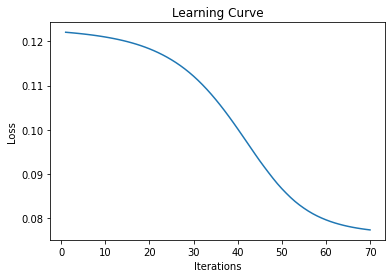

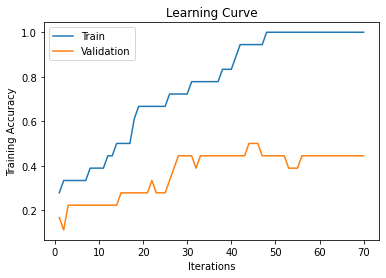

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.4444444444444444


In [ ]:
model1 = CNN1()
train(model1, overfit_train, overfit_valid, batch_size=18, weight_decay=0.0,
          optimizer="adam", momentum=0.9, learning_rate=0.0001, num_epochs=70,
          shuffle_data=True, checkpoint_path=None)


 ----- Start Training ----- 

Iter 1. [Val Acc 11%] [Train Acc 11%, Loss 0.122237]
Iter 2. [Val Acc 11%] [Train Acc 11%, Loss 0.104799]
Iter 3. [Val Acc 11%] [Train Acc 11%, Loss 0.088628]
Iter 4. [Val Acc 11%] [Train Acc 11%, Loss 0.081030]
Iter 5. [Val Acc 11%] [Train Acc 11%, Loss 0.077771]
Iter 6. [Val Acc 11%] [Train Acc 11%, Loss 0.076863]
Iter 7. [Val Acc 11%] [Train Acc 11%, Loss 0.076523]
Iter 8. [Val Acc 11%] [Train Acc 11%, Loss 0.076368]
Iter 9. [Val Acc 17%] [Train Acc 22%, Loss 0.076294]
Iter 10. [Val Acc 17%] [Train Acc 22%, Loss 0.076259]
Iter 11. [Val Acc 17%] [Train Acc 22%, Loss 0.076241]
Iter 12. [Val Acc 11%] [Train Acc 17%, Loss 0.076232]
Iter 13. [Val Acc 11%] [Train Acc 17%, Loss 0.076227]
Iter 14. [Val Acc 11%] [Train Acc 17%, Loss 0.076225]
Iter 15. [Val Acc 11%] [Train Acc 17%, Loss 0.076223]
Iter 16. [Val Acc 11%] [Train Acc 17%, Loss 0.076222]
Iter 17. [Val Acc 11%] [Train Acc 17%, Loss 0.076221]
Iter 18. [Val Acc 11%] [Train Acc 17%, Loss 0.076221]
Iter 1

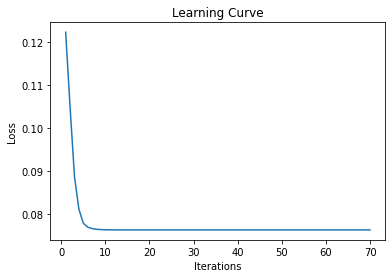

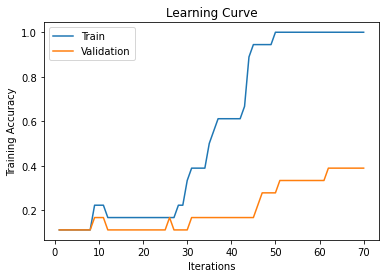

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.3888888888888889


In [ ]:
model2 = CNN2()
train(model2, overfit_train, overfit_valid, batch_size=18, weight_decay=0.0,
          optimizer="adam", momentum=0.9, learning_rate=0.0001, num_epochs=70,
          shuffle_data=True, checkpoint_path=None)

## Question 4. Training

### Part (a) -- 5 points

Train your first network on your training set.
Plot the training curve, and include your plot in your writeup.

Make sure that you are checkpointing frequently!


 ----- Start Training ----- 

Iter 10. [Val Acc 9%] [Train Acc 11%, Loss 0.030148]
Iter 20. [Val Acc 32%] [Train Acc 31%, Loss 0.029556]
Iter 30. [Val Acc 60%] [Train Acc 54%, Loss 0.027109]
Iter 40. [Val Acc 66%] [Train Acc 62%, Loss 0.024963]
Iter 50. [Val Acc 71%] [Train Acc 65%, Loss 0.024450]
Iter 60. [Val Acc 73%] [Train Acc 71%, Loss 0.022661]
Iter 70. [Val Acc 70%] [Train Acc 71%, Loss 0.023557]
Iter 80. [Val Acc 74%] [Train Acc 75%, Loss 0.022117]
Iter 90. [Val Acc 71%] [Train Acc 76%, Loss 0.022328]
Iter 100. [Val Acc 75%] [Train Acc 77%, Loss 0.020594]
Iter 110. [Val Acc 72%] [Train Acc 78%, Loss 0.022471]
Iter 120. [Val Acc 76%] [Train Acc 80%, Loss 0.021393]
Iter 130. [Val Acc 72%] [Train Acc 82%, Loss 0.022844]
Iter 140. [Val Acc 76%] [Train Acc 83%, Loss 0.021529]
Iter 150. [Val Acc 76%] [Train Acc 84%, Loss 0.020366]
Iter 160. [Val Acc 77%] [Train Acc 85%, Loss 0.021101]
Iter 170. [Val Acc 73%] [Train Acc 86%, Loss 0.021642]
Iter 180. [Val Acc 74%] [Train Acc 86%, Loss

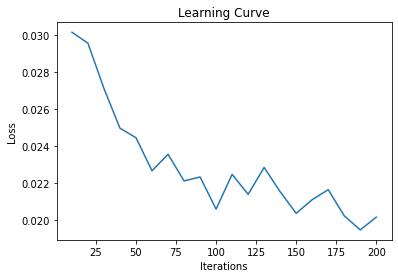

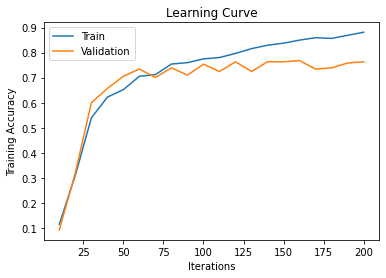

Final Training Accuracy: 0.8813096862210096
Final Validation Accuracy: 0.7632850241545893


In [ ]:
# Your code goes here. Make sure to include the training curve.
model1=CNN1()

output_channels = model1.out_channels//2//2
checkpoint_path = f'/content/drive/MyDrive/Colab Notebooks/CSC413/A2/Checkpoints/model1/ckpt-out{output_channels}.txt'

# if os.stat(checkpoint_path).st_size != 0:
#    print("Loaded Weights from", checkpoint_path)
#    model1.load_state_dict(torch.load(checkpoint_path))

train(model1, train_data, valid_data, batch_size=73, weight_decay=0.0,
          optimizer="adam", momentum=0.9, learning_rate=0.0001, num_epochs=20,
          shuffle_data=True, checkpoint_path=None, print_acc=True)

### Part (b) -- 2 points

You should have tried several hyperparameter choices before deciding on one set
of hyperparameters to use for Part (a).
In this section, briefly explain the hyperparamter choices that you tried,
and how they impacted your training.

In [ ]:
# Your explanation goes here.

# Used Adam instead of SGD since Adam is much faster during training.
# We can train the whole model with Adam in 20 mins but SGD takes more than the time we could wait.
# And SGD is stuck at 33% training accuracy probably because

# Chose momentum to be 0.9 because it is the value generally good with lr of 0.001 and it is also the defult value in PyTorch's Adam

# Did not use weight decay since the training accuracy is close to validation accuracy.

# Batch size = 73 since larger batch size will run out of RAM and smaller batch size will train slower as we tested so far.

### Part (c) -- 5 points

Train your second network on your training set.
Plot the training curve, and include your plot in your writeup.

Make sure that you are checkpointing frequently!


 ----- Start Training ----- 

Iter 10. [Val Acc 13%] [Train Acc 12%, Loss 0.028927]
Iter 20. [Val Acc 15%] [Train Acc 23%, Loss 0.026232]
Iter 30. [Val Acc 34%] [Train Acc 47%, Loss 0.024122]
Iter 40. [Val Acc 44%] [Train Acc 51%, Loss 0.021888]
Iter 50. [Val Acc 69%] [Train Acc 86%, Loss 0.020227]
Iter 60. [Val Acc 71%] [Train Acc 92%, Loss 0.020293]
Iter 70. [Val Acc 76%] [Train Acc 96%, Loss 0.020552]
Iter 80. [Val Acc 78%] [Train Acc 97%, Loss 0.019877]
Iter 90. [Val Acc 78%] [Train Acc 98%, Loss 0.019392]
Iter 100. [Val Acc 77%] [Train Acc 98%, Loss 0.019490]


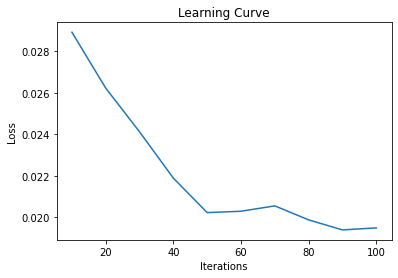

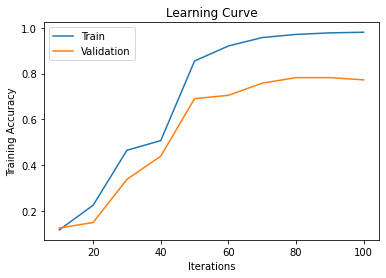

Final Training Accuracy: 0.9809004092769441
Final Validation Accuracy: 0.7729468599033816


In [ ]:
# Your code goes here. Make sure to include the training curve.
model2=CNN2()

output_channels = model2.out_channels//2//2
checkpoint_path = f'/content/drive/MyDrive/Colab Notebooks/CSC413/A2/Checkpoints/model2/ckpt-out{output_channels}.txt'

# if os.stat(checkpoint_path).st_size != 0:
#    print("Loaded Weights from", checkpoint_path)
#    model1.load_state_dict(torch.load(checkpoint_path))

train(model2, train_data, valid_data, batch_size=73, weight_decay=0.001,
          optimizer="adam", momentum=0.9, learning_rate=0.0001, num_epochs=10,
          shuffle_data=True, checkpoint_path=checkpoint_path, print_acc=True)

### Part (d) -- 2 points

You should have tried several hyperparameter choices before deciding on one set
of hyperparameters to use for Part (c).
In this section, briefly explain the hyperparamter choices that you tried,
and how they impacted your training.

In [ ]:
# Your explanation goes here.

# Used Adam instead of SGD since Adam is much faster during training. And SGD will stuck at 33% training accuracy.

# We used lr = 0.0001 since when we are testing several hypermaters, we found that we cannot reproduce the experiment.
# Therefore, we think that might be the case learning rate is too high such that the gradient is instabile.
# After we reduced the lr, the model converges really fast.

# Weight decay = 0.001 since the training accuracy without weight decay is 96% while the validation accuracy is around 65%, which is a 30% difference.
# Therefore, the model might overfit so we introduced weight decay.

# Batch size = 73 since larger batch size will run out of RAM and smaller batch size will train slower.

### Part (e) -- 1 pts

Out of all the models (i.e. parts (a) vs (c), and the various hyperparameter choices)
that you tried, which model is the "best"?
If you were to select a single set of weight values (checkpoints)
to deploy and use in a real application, which would you choose?

In [ ]:
# Your explanation goes here.


## Question 5. Transfer Learning

For many image classification tasks, it is generally not a good idea to train a
very large deep neural network model from scratch due to the enormous compute
requirements and lack of sufficient amounts of training data.

One of the better options is to try using an existing model that performs a
similar task to the one you need to solve. This method of using a
pre-trained network for other similar tasks is broadly termed
**Transfer Learning**. In this question, we will use Transfer Learning
to extract features from the hand gesture images. Then, train a smaller
network to use these features as input and classify the hand gestures.

As you have learned from the CNN lecture, the AlexNet architecture played a pivotal role in
establishing Deep Neural Nets as a go-to tool for image classification
problems and we will use an ImageNet pre-trained AlexNet model to
extract features in this assignment.

### Part (a)

Here is the code to load the AlexNet network, with pretrained weights.
When you first run the code, PyTorch will download the pretrained weights
from the internet.

In [ ]:
import torchvision.models
alexnet = torchvision.models.alexnet(pretrained=True)

The `alexnet` model is split up into two components: `alexnet.features` and
`alexnet.classifier`.  The first neural network component, `alexnet.features`,
is used to
computed convolutional features, which is taken as input in `alexnet.classifier`.

The neural network `alexnet.features` expects an image tensor of shape
Nx3x224x224 as inputs and it will output a tensor of shape Nx256x6x6 . (N = batch size).

Here is an example code snippet showing how you can compute the AlexNet
features for some images (your actual code might be different):

In [ ]:
img, label = train_data[0]
features = alexnet.features(img.unsqueeze(0)).detach()

Note that the `.detach()` at the end will be necessary in your code. The reason is that
PyTorch automatically builds computation graphs to be able to backpropagate
gradients. If we did not explicitly "detach" this tensor from the AlexNet portion
of the computation graph, PyTorch might try to backpropagate gradients to the AlexNet
weight and tune the AlexNet weights.

Compute the AlexNet features for each of your training, validation, and test data.
In other words, create three new arrays called `train_data_features`, `valid_data_features`
and `test_data_features`. Each of these arrays should contain tuples of the form
`(alexnet_features, label)`

In [ ]:
# Modify this code

train_data_features = []
valid_data_features = []
test_data_features = []
for img, y in train_data:
  features = alexnet.features(img.unsqueeze(0)).detach()
  train_data_features.append((features, y))
for img, y in valid_data:
  features = alexnet.features(img.unsqueeze(0)).detach()
  valid_data_features.append((features, y))
for img, y in test_data:
  features = alexnet.features(img.unsqueeze(0)).detach()
  test_data_features.append((features, y))

### Part (b)


Create a multi-layer preceptron that
takes **as input** these AlexNet features,
and makes a prediction. Your model should be a subclass of `nn.Module`.

In [ ]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        # ... todo ...
        self.conv1 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc = nn.Linear(512, 3, 3, 9)

    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = x.view(-1, 512 * 3 * 3)
        x = self.fc(x)
        return x

### Part (c)

Train the `MLP()` model for at least 6 epochs, and report
on the maximum validation accuracy that you can attain.

This model should train *much* faster since it has very few parameters.
However, this model should attain much better accuracy much faster!

In [ ]:
mlp = MLP()
train(mlp, train_data, valid_data)

RuntimeError: ignored

## Question 6. Test Accuracy

### Part (a) -- 5 pts

Report the test accuracies of your **single best** model for the test set, including
any model that you trained (including in Q5).

In [ ]:
# Write your code here. Make sure to include the test accuracy in your report
get_accuracy(mlp, test_data_features)

### Part (b) -- 1 pts

Display one image that your model correctly classified.

In [ ]:
# Make sure both your code and image are visible to the TA

### Part (b) -- 1 pts

Display one image that your model incorrectly classified. (If your test performance was 100%, please just say so.)

In [ ]:
# Make sure both your code and image are visible to the TA

## Question 6. Adversarial Examples -- 2 pts

In this question you will take the trained model you selected in Q4 (e),
and you will freeze its weights (i.e. do not optimize it further). Let's call this model $f()$.
Select an image (let's call it $x$) from the test set, where $f(x)$ outputs the correct label $y$.
Then, compute an adversarial noise image (let's call it $n$) that you will add to $x$ in order to change
the original label to an incorrect one, i.e. $f(x + n) \neq f(x)$, while keeping the value of the noise
pixels small, i.e. $|n_{i,j}| < \epsilon$. You have control over $\epsilon$, but keep in mind that the
noise should be imperceptible to the human eye when not zooming into the image.

In [ ]:
#
# Make sure your code, original image x, and the corrupted image x + n are shown to the TA
# Show the output f(x) = y and the output f(x + n) is different than y.
#

## Question 7. Work Allocation -- 1 pts

This question is to make sure that if you are working with a partner, that
you and your partner contributed equally to the assignment.

Please have each team member write down the times that you worked on the
assignment, and your contribution to the assignment.

In [ ]:
# Your answer goes here
# Steven Shi: 23 times
# Xuankui Zhu: 17 times